In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def add_month(df):
    new_index = [] 
    for i, index_value in enumerate(df.index):
        iteration = i % 12 + 1
        new_index.append(f'{index_value}-{iteration}')
    df.index = new_index

    return df

In [9]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

In [10]:
df = read_csv_replace_missing_by_polynomial('pib_mato_grosso_do_sul.csv', 0, 0)
df.head(len(df))

,Ano,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado
0,1985,1.036170e+07,1.839822e+06,12.427728,2.515180e+07
1,1986,1.195770e+07,1.882633e+06,12.691120,2.615875e+07
2,1987,1.374828e+07,1.914972e+06,12.993680,2.723041e+07
3,1988,1.569973e+07,1.965380e+06,13.289978,2.829358e+07
4,1989,1.781169e+07,2.000860e+06,13.573210,2.936264e+07
5,1990,2.015744e+07,2.029119e+06,13.875090,3.046306e+07
6,1991,2.255475e+07,2.069601e+06,14.153032,3.149405e+07
7,1992,2.513808e+07,2.108245e+06,14.421331,3.250704e+07
8,1993,2.775732e+07,2.133815e+06,14.677669,3.349075e+07
9,1994,3.058223e+07,2.150327e+06,14.944501,3.449855e+07


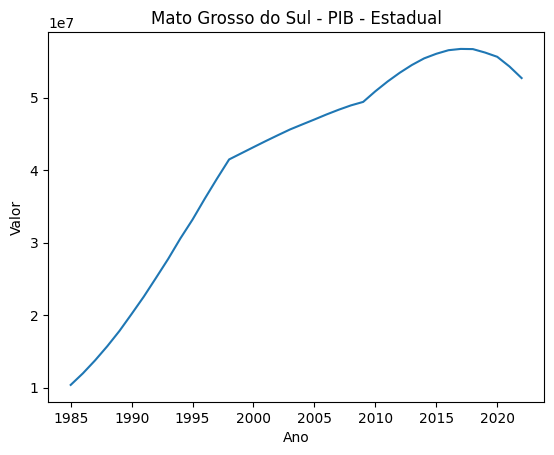

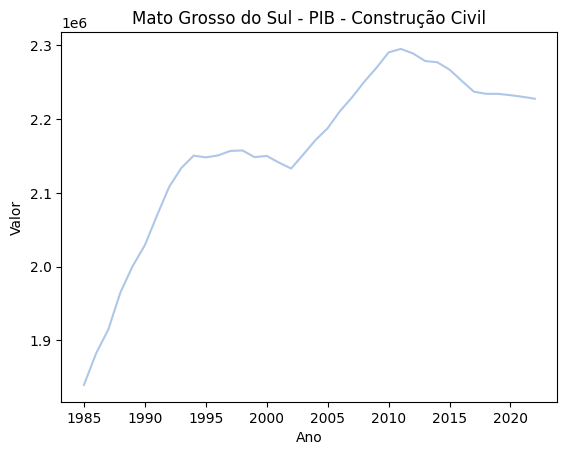

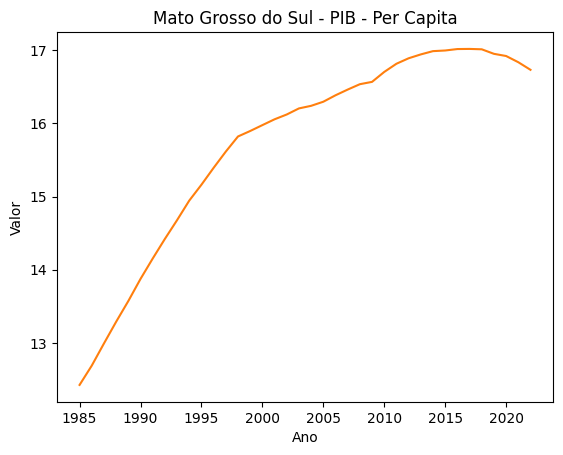

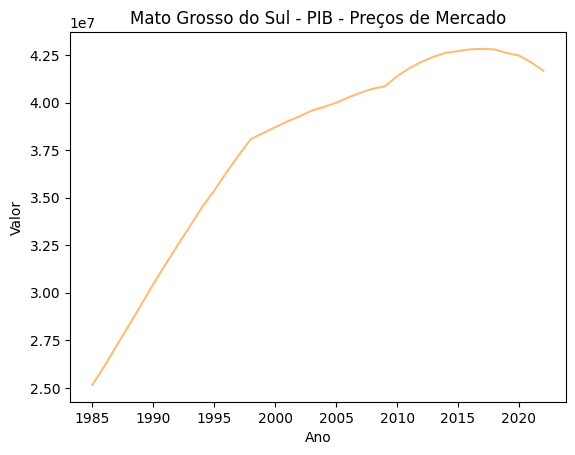

In [11]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
plot_columns(df_year)

In [12]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado
Ano,,,,
2003,4.562945e+07,2.151917e+06,16.203179,3.957545e+07
2004,4.632078e+07,2.171425e+06,16.238609,3.976863e+07
2005,4.700352e+07,2.187532e+06,16.294466,3.998653e+07
2006,4.770379e+07,2.210487e+06,16.382367,4.026684e+07
2007,4.835689e+07,2.229287e+06,16.460417,4.051516e+07
2008,4.895245e+07,2.250403e+06,16.533879,4.072450e+07
2009,4.943099e+07,2.269266e+06,16.565699,4.085410e+07
2010,5.089988e+07,2.290154e+06,16.701299,4.138190e+07
2011,5.224283e+07,2.294876e+06,16.813003,4.180160e+07


In [13]:
def dataframe_expanded_interpolation(df):
    expanded_df = pd.DataFrame(columns=df.columns)
    for i, (_, row) in enumerate(df.iterrows()):
        if i > 0:
            expanded_df = pd.concat([expanded_df, pd.DataFrame(columns=df.columns, index=[None] * 11)])
        expanded_df = pd.concat([expanded_df, pd.DataFrame(row).T])
    expanded_df = expanded_df.reset_index(drop=True)
    expanded_df.interpolate(method='linear', axis=0, inplace=True)

    return expanded_df

def add_ano_column(df):
    new_df = df.copy()
    ano_start = 2002
    for i in range(len(new_df)):
        if i % 12 == 0:
            ano_start += 1
        new_df.at[i, 'Ano'] =  str(ano_start)

    return new_df

In [14]:
pd.set_option('display.max_rows', None)
df_mo_2003 = dataframe_expanded_interpolation(df_2003)
df_mo_2003 = add_ano_column(df_mo_2003)
df_mo_2003 = df_mo_2003.set_index('Ano', inplace=False)
df_mo_2003 = add_month(df_mo_2003)
df_mo_2003

,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado
2003-1,4.562945e+07,2.151917e+06,16.203179,3.957545e+07
2003-2,4.568706e+07,2.153542e+06,16.206131,3.959155e+07
2003-3,4.574467e+07,2.155168e+06,16.209084,3.960765e+07
2003-4,4.580228e+07,2.156794e+06,16.212036,3.962375e+07
2003-5,4.585990e+07,2.158419e+06,16.214989,3.963985e+07
2003-6,4.591751e+07,2.160045e+06,16.217941,3.965595e+07
2003-7,4.597512e+07,2.161671e+06,16.220894,3.967204e+07
2003-8,4.603273e+07,2.163297e+06,16.223846,3.968814e+07
2003-9,4.609034e+07,2.164922e+06,16.226799,3.970424e+07
2003-10,4.614795e+07,2.166548e+06,16.229751,3.972034e+07


In [15]:
df_mo_2003.to_csv('2003_mo_pib.csv')

In [10]:
df_2003.to_csv('2003_01_pib.csv')

In [21]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado
Ano,,,,
2014,3.422472e+08,1.797983e+07,14.350903,2.842942e+08
2015,3.447299e+08,1.774932e+07,14.320707,2.838475e+08
2016,3.468708e+08,1.763097e+07,14.321241,2.839239e+08
2017,3.480263e+08,1.759670e+07,14.339149,2.842415e+08
2018,3.478564e+08,1.765850e+07,14.350033,2.842853e+08
2019,3.458997e+08,1.772657e+07,14.340136,2.839888e+08
2020,3.419474e+08,1.776504e+07,14.319860,2.833436e+08
2021,3.358227e+08,1.778033e+07,14.306167,2.826747e+08
2022,3.283935e+08,1.780864e+07,14.289270,2.818346e+08


In [20]:
df_2014.to_csv('2014_01_pib.csv')

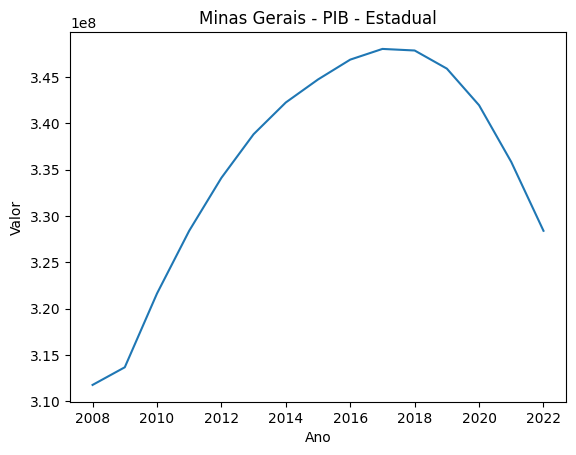

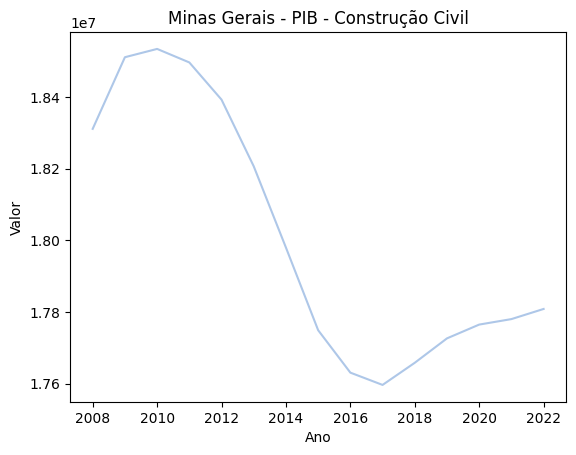

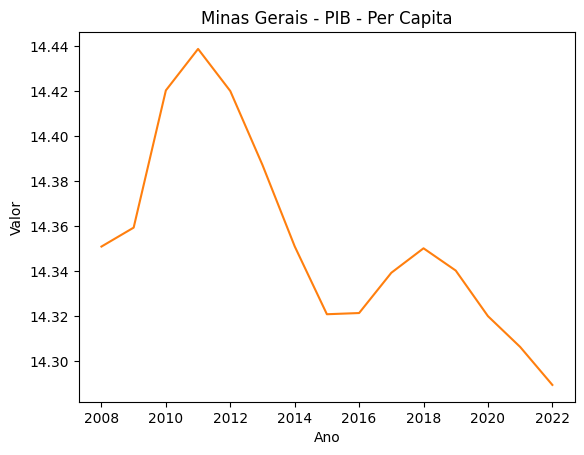

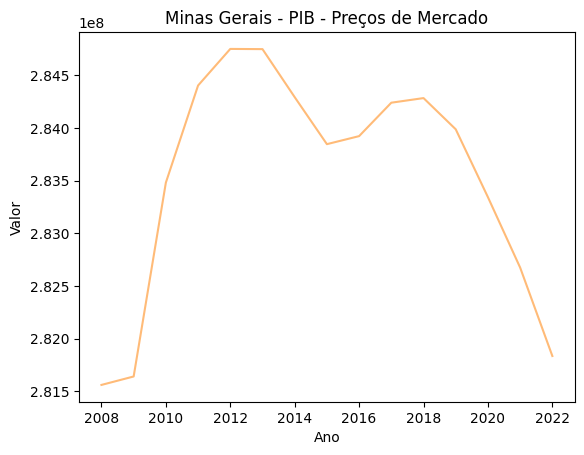

,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado
Ano,,,,
2008,3.117564e+08,1.831109e+07,14.350809,2.815599e+08
2009,3.136613e+08,1.851096e+07,14.359230,2.816401e+08
2010,3.216212e+08,1.853410e+07,14.420260,2.834821e+08
2011,3.283955e+08,1.849638e+07,14.438708,2.844049e+08
2012,3.341102e+08,1.839259e+07,14.419985,2.847525e+08
2013,3.388207e+08,1.820659e+07,14.387080,2.847505e+08
2014,3.422472e+08,1.797983e+07,14.350903,2.842942e+08
2015,3.447299e+08,1.774932e+07,14.320707,2.838475e+08
2016,3.468708e+08,1.763097e+07,14.321241,2.839239e+08


In [22]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

In [23]:
df_2008.to_csv('2008_01_pib.csv')